# Demo of STARCOP models on AVIRIS data

Demos with model loading and inference on AVIRIS data from the test set.

In [ ]:
!pip install --quiet rasterio
!pip install --quiet --upgrade gdown

In [ ]:
# Clone the repository:
!git clone https://github.com/spaceml-org/STARCOP.git

In [2]:
# Data:
# STARCOP_mini.zip with 261 MB
!gdown https://drive.google.com/uc?id=1Qw96Drmk2jzBYSED0YPEUyuc2DnBechl -O STARCOP_mini.zip

# Models:
!gdown https://drive.google.com/uc?id=1TXFlAHO_eRdfbJGLNNt3KY0lJqjm3fdX -O multistarcop_varon.zip
!gdown https://drive.google.com/uc?id=1Kvnc_lOBn4z-xO1HFRyLZOMEldXWQvql -O hyperstarcop_magic_rgb.zip

Downloading...
From (uriginal): https://drive.google.com/uc?id=1Qw96Drmk2jzBYSED0YPEUyuc2DnBechl
From (redirected): https://drive.google.com/uc?id=1Qw96Drmk2jzBYSED0YPEUyuc2DnBechl&confirm=t&uuid=84d0a614-90bf-4cc3-909d-23e973ef9c80
To: /content/STARCOP_mini.zip
100% 274M/274M [00:07<00:00, 34.9MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1TXFlAHO_eRdfbJGLNNt3KY0lJqjm3fdX
From (redirected): https://drive.google.com/uc?id=1TXFlAHO_eRdfbJGLNNt3KY0lJqjm3fdX&confirm=t&uuid=16d04c85-c718-4c45-82ff-c3950be39bc7
To: /content/multistarcop_varon.zip
100% 73.5M/73.5M [00:02<00:00, 31.1MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1Kvnc_lOBn4z-xO1HFRyLZOMEldXWQvql
From (redirected): https://drive.google.com/uc?id=1Kvnc_lOBn4z-xO1HFRyLZOMEldXWQvql&confirm=t&uuid=704f662a-8e8b-4179-bb8d-063cabe0b4a5
To: /content/hyperstarcop_magic_rgb.zip
100% 73.3M/73.3M [00:02<00:00, 34.4MB/s]


In [4]:
!unzip -q STARCOP_mini.zip
!unzip -q multistarcop_varon.zip
!unzip -q hyperstarcop_magic_rgb.zip
# clean-up
!rm *.zip

In [5]:
!ls

hyperstarcop_magic_rgb	multistarcop_varon  sample_data  STARCOP  STARCOP_mini


In [6]:
%cd /content/STARCOP

/content/STARCOP


In [ ]:
!pip --quiet install -r requirements.txt
# ignore the warnings about the library versions

In [ ]:
# additional libraries and exact versions:
!pip install git+https://github.com/spaceml-org/georeader.git
!pip install torchtext==0.14.1

In [ ]:
assert False
# please restart the runtime with the button above ^

In [1]:
%cd /content/STARCOP

/content/STARCOP


In [4]:
import omegaconf
import pylab as plt
import torch
import omegaconf
import fsspec
import os
import json
import pandas as pd
import numpy as np
from starcop.torch_utils import to_device
import starcop.plot as starcoplot
from mpl_toolkits.axes_grid1 import make_axes_locatable

from starcop.data.datamodule import Permian2019DataModule
from starcop.models.model_module import ModelModule
from starcop.validation import run_validation

device = torch.device("cuda:0")
fs = fsspec.filesystem("gs")
config_general = omegaconf.OmegaConf.load("scripts/configs/config.yaml")
root_folder = "/content/STARCOP_mini"

## HyperSTARCOP

In [5]:
hsi_model_path = "/content/hyperstarcop_magic_rgb/final_checkpoint_model.ckpt"
hsi_config_path = "/content/hyperstarcop_magic_rgb/config.yaml"

In [6]:
def load_model_with_datamodule(model_path, config_path):
    config_model = omegaconf.OmegaConf.load(config_path)
    config = omegaconf.OmegaConf.merge(config_general, config_model)

    import ast
    dataset_dict = ast.literal_eval(config_model['_content']['value']['dataset'])
    dataset_dict['root_folder'] = root_folder
    dataset_dict['train_csv'] = '/content/STARCOP_mini/train_mini10.csv'
    config.dataset = dataset_dict
    config.products_plot = config_model['_content']['value']['products_plot']

    data_module = Permian2019DataModule(config)
    data_module.test_csv = '/content/STARCOP_mini/test_mini10.csv'
    data_module.settings['dataset'] = dataset_dict
    data_module.prepare_data()

    model = ModelModule.load_from_checkpoint(model_path, settings=config)
    model.to(device)
    model.eval() # !

    print("Loaded model with",model.num_channels,"input channels, data module with", len(data_module.input_products), "inputs:", data_module.input_products, ", for plotting we use these products:", config.products_plot)

    return model, data_module, config

hsi_model, hsi_dm, hsi_config = load_model_with_datamodule(hsi_model_path, hsi_config_path)
print("successfully loaded HyperSTARCOP model!")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Computing label statistics: 100%|██████████| 441/441 [00:02<00:00, 148.14it/s]


Loaded model with 4 input channels, data module with 4 inputs: ['mag1c', 'TOA_AVIRIS_640nm', 'TOA_AVIRIS_550nm', 'TOA_AVIRIS_460nm'] , for plotting we use these products: ['rgb_aviris', 'mag1c', 'label', 'pred', 'differences']
successfully loaded HyperSTARCOP model!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


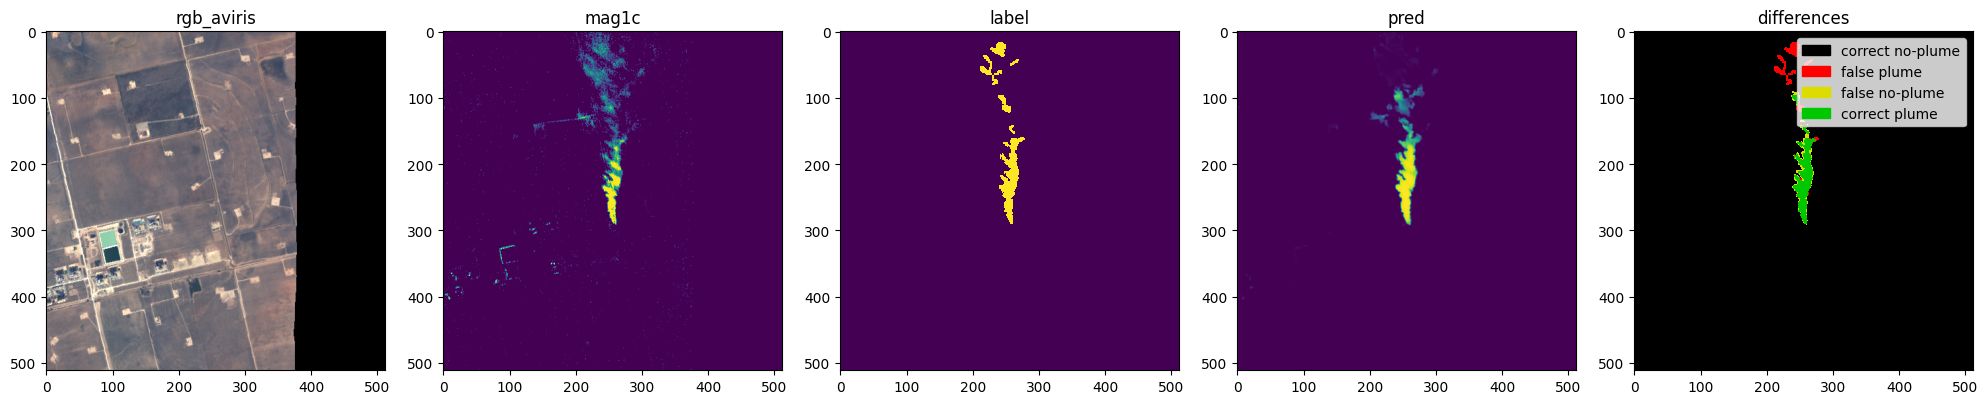

In [7]:
dataloader = hsi_dm.test_dataloader(batch_size=1)
how_many = 1
for i, plume_data in enumerate(dataloader):
    plume_data = hsi_model.batch_with_preds(to_device(plume_data, hsi_model.device))
    fig = starcoplot.plot_batch(to_device(plume_data,"cpu"), input_products=hsi_config.dataset.input_products,
                                products_plot=hsi_config.products_plot, figsize_ax=(4, 4))

    plt.show(fig)
    plt.close()

    how_many -=1
    if how_many <= 0: break

In [ ]:
# from starcop.validation import run_validation
# dataloader = hsi_dm.test_dataloader(batch_size=1)
# hsi_metrics_per_id, hsi_metrics = run_validation(hsi_model, dataloader, products_plot=hsi_config.products_plot, verbose=True,
#                                           show_plots=True, skip_saving_plots=True, # < for showing
#                                           #show_plots=False, skip_saving_plots=False, # < for saving
#                                           path_save_results="hyperstarcop_outputs")

# # Note: The metrics on this small subset, don't make much sense

## MultiSTARCOP

In [8]:
msi_model_path = "/content/multistarcop_varon/final_checkpoint_model.ckpt"
msi_config_path = "/content/multistarcop_varon/config.yaml"

msi_model, msi_dm, msi_config = load_model_with_datamodule(msi_model_path, msi_config_path)
print("Successfully loaded MultiSTARCOP model!")

Feature ratio_wv3_B7_B5_varon21_sum_c_out does not exists. It will be generated
Feature ratio_wv3_B8_B5_varon21_sum_c_out does not exists. It will be generated
Feature ratio_wv3_B7_B6_varon21_sum_c_out does not exists. It will be generated


100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


Feature ratio_wv3_B7_B5_varon21_sum_c_out does not exists. It will be generated
Feature ratio_wv3_B8_B5_varon21_sum_c_out does not exists. It will be generated
Feature ratio_wv3_B7_B6_varon21_sum_c_out does not exists. It will be generated


100%|██████████| 9/9 [00:02<00:00,  3.08it/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Loaded model with 3 input channels, data module with 3 inputs: ['ratio_wv3_B7_B5_varon21_sum_c_out', 'ratio_wv3_B8_B5_varon21_sum_c_out', 'ratio_wv3_B7_B6_varon21_sum_c_out'] , for plotting we use these products: ['wv3_ratios_varon_b7b5', 'wv3_ratios_varon_b8b5', 'wv3_ratios_varon_b7b6', 'label', 'pred', 'differences']
Successfully loaded MultiSTARCOP model!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


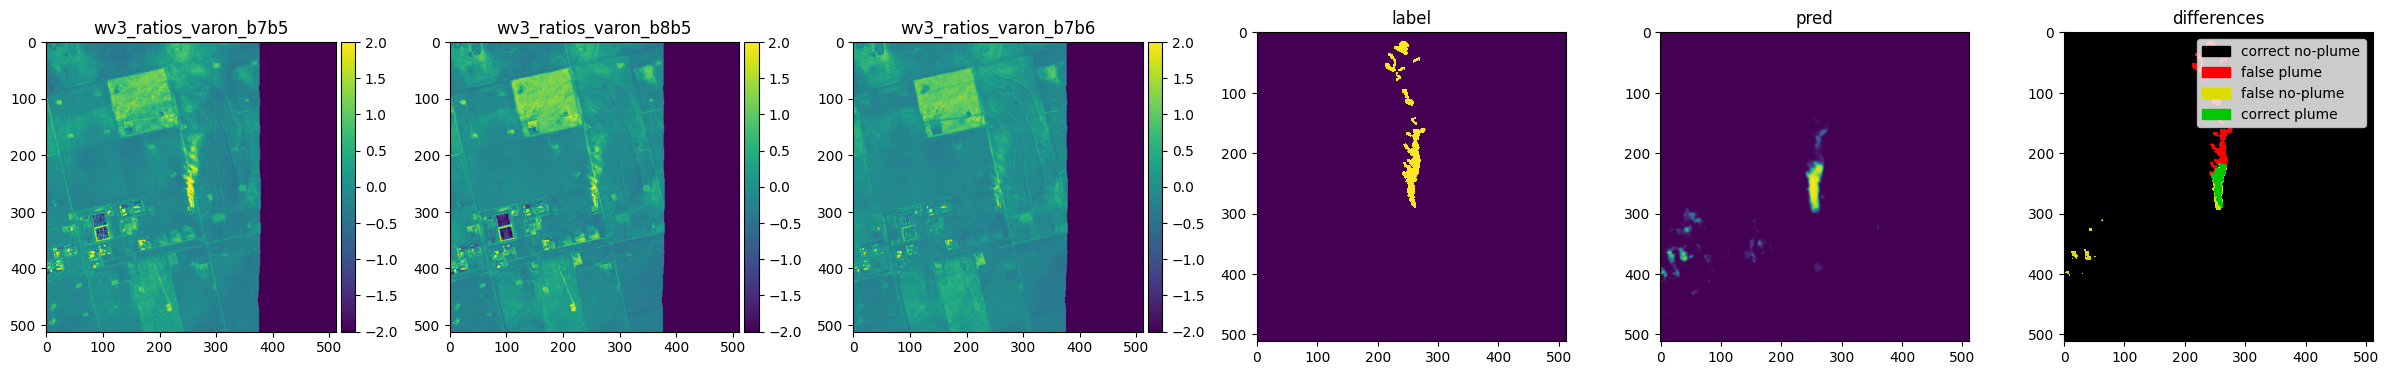

In [9]:
dataloader = msi_dm.test_dataloader(batch_size=1)
how_many = 1
for i, plume_data in enumerate(dataloader):
    plume_data = msi_model.batch_with_preds(to_device(plume_data, msi_model.device))
    fig = starcoplot.plot_batch(to_device(plume_data,"cpu"), input_products=msi_config.dataset.input_products,
                                products_plot=msi_config.products_plot, figsize_ax=(4, 4))

    plt.show(fig)
    plt.close()

    how_many -=1
    if how_many <= 0: break


In [ ]:
# from starcop.validation import run_validation
# dataloader = msi_dm.test_dataloader(batch_size=1)
# msi_metrics_per_id, msi_metrics = run_validation(msi_model, dataloader, products_plot=msi_config.products_plot, verbose=True,
#                                           show_plots=True, skip_saving_plots=True, # < for showing
#                                           #show_plots=False, skip_saving_plots=False, # < for saving
#                                           path_save_results="multistarcop_outputs")

# # Note: The metrics on this small subset, don't make much sense